## 1.- Download and save the text 

In [1]:
import requests
import pandas as pd

url = "https://www.gutenberg.org/cache/epub/1581/pg1581.txt"
response = requests.get(url)

if response.status_code == 200:
    with open("Douay-Rheims.txt", "w",encoding="utf-8") as file:
        file.write(response.text,)
    print("File downloaded successfully!")
else:
    print("Failed to download file. Status code:", response.status_code)

File downloaded successfully!


## 2. Parsing 

In this section we parese the bible in chapter and verses.
The logic is simple, we find all the chapter titles using regular expressions, and we use that to split. 
There are foot notes and annotations, particularly in the end, however we are only interested in Bible verses, so after we split by \n\n\n\n, we only keep those lines that start wit \d+:\d+ i.e chapter and verse like 12:5 etc. 


In [2]:
import re
# Sample text
with open('Douay-Rheims.txt', 'r',encoding="utf-8") as f:
    text = f.read()
expression = re.compile(r"(?=^.+Chapter \d+)", re.MULTILINE)
chapters = re.split(expression,text)

In [3]:
# Find all the chapters
expression = re.compile(r"^.+Chapter \d+", re.MULTILINE)
chapter_names =re.findall(expression,text)


In [4]:
# Split the bible in chapters
expression = re.compile(r"(?=^.+Chapter \d+)", re.MULTILINE)
chapters = re.split(expression,text)

bible_dict = {'book':[],'chapter':[], 'verse':[],'text':[]}

# Split the chapters in verses
verses_regex = re.compile(r"\n\n\n\n", re.MULTILINE)
verse_number_regex = re.compile(r"^\d+:\d+\. ", re.MULTILINE)


from collections import namedtuple
Verse = namedtuple('Verse', ['book','chapter', 'verse', 'text'])
verse_number_regex = re.compile(r"^\d+:\d+\. ", re.MULTILINE)


def separate_verse_num(x,c):
    m= re.findall(verse_number_regex,x)
    vn = re.sub(r"\. ",r"",m[0]).split(":")
    text = re.sub(verse_number_regex,r"",x)
    book_name = re.sub(r' Chapter \d+.*',r'',c)
    return Verse(book=book_name ,chapter=vn[0],verse=vn[1],text=text)

n = len(chapter_names)
for c in range(n):
    verses = [separate_verse_num(x,chapter_names[c]) for x in re.split(verses_regex,chapters[c+1]) if re.match(r"(?=^\d+:\d+\. )",x)]
    for v in verses:
        bible_dict['book'].append(v[0])
        bible_dict['chapter'].append(v[1])
        bible_dict['verse'].append(v[2])
        bible_dict['text'].append(v[3])
        


In [5]:
b =pd.DataFrame(bible_dict)
b.head()

book chapter verse                                               text
0  Genesis       1     1    In the beginning God created heaven, and earth.
1  Genesis       1     2  And the earth was void and empty, and darkness...
2  Genesis       1     3   And God said: Be light made. And light was made.
3  Genesis       1     4  And God saw the light that it was good; and he...
4  Genesis       1     5  And he called the light Day, and the darkness ...

In [6]:
b['book'].unique()

array(['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Josue', 'Judges', 'Ruth', '1 Kings', '2 Kings', '3 Kings',
       '4 Kings', '1 Paralipomenon', '2 Paralipomenon', '1 Esdras',
       '2 Esdras', 'Tobias', 'Judith', 'Esther', 'Job', 'Psalms',
       'Proverbs', 'Ecclesiastes', 'Canticle of Canticles', 'Wisdom',
       'Ecclesiasticus', 'Isaias', 'Jeremias', 'Lamentations', 'Baruch',
       'Ezechiel', 'Daniel', 'Osee', 'Joel', 'Amos', 'Abdias', 'Jonas',
       'Micheas', 'Nahum', 'Habacuc', 'Sophonias', 'Aggeus', 'Zacharias',
       'Malachias', '1 Machabees', '2 Machabees', 'Matthew', 'Mark',
       'Luke', 'John', 'Acts', 'Romans', '1 Corinthians', '2 Corinthians',
       'Galatians', 'Ephesians', 'Philippians', 'Colossians',
       '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy',
       'Titus', 'Philemon', 'Hebrews', 'James', '1 Peter', '2 Peter',
       '1 John', '2 John', '3 John', 'Jude', 'Apocalypse'], dtype=object)

As a sanity check, we review that Apocalypse Chapter 22 looks nice. It is the last book and wanted to double chech that all versers are there and no extranues notes are present

In [7]:

# for i,row in b.loc[b['book']=='Apocalypse',:].iterrows():
#    print(row['chapter'],row['verse'],row['text'])


In [8]:
#!pip install -U sentence-transformers

In [9]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-cos-v5')

Now, we embedd all the verses across all chapters

In [59]:
import time 
r = b.shape[0]

bc = {'book':[],'chapter':[],'text':[]}

prev_book =''
prev_chapter =''
text = ' '

for i in range(r):
    row = b.loc[i,:]
    if prev_book == row['book'] and prev_chapter==row['chapter']:
        text = text + " " + row['text']
    else:
        bc['book'].append(prev_book)
        bc['chapter'].append(prev_chapter)
        bc['text'].append(text)
        
        prev_book = row['book']
        prev_chapter = row['chapter']
        text = row['text']

bc['book'].append(prev_book)
bc['chapter'].append(prev_chapter)
bc['text'].append(text)

bc = pd.DataFrame(bc)
bc = bc.iloc[1:]

    

In [60]:
bc.shape

(1334, 3)

In [62]:
bc.head()

book chapter                                               text
1  Genesis       1  In the beginning God created heaven, and earth...
2  Genesis       2  So the heavens and the earth were finished, an...
3  Genesis       3  Now the serpent was more subtle than any of th...
4  Genesis       4  And Adam knew Eve his wife; who conceived and ...
5  Genesis       5  This is the book of the generation of Adam. In...

In [63]:
# bc['encoded'] = bc['text'].map(model.encode)

In [65]:
import pickle
# with open('bible_chapters_df.pkl', 'wb') as file:
#     # Dump the object to the file
#     pickle.dump(bc, file)

with open('bible_chapters_df.pkl', 'rb') as file:
    bc = pickle.load(file)

In [67]:
bc.shape

(1334, 4)

In [68]:
# Create a Matrix
matrix = bc['encoded']


In [69]:
import numpy as np
matrix = np.array([np.array(m) for m in matrix])
matrix.shape

(1334, 768)

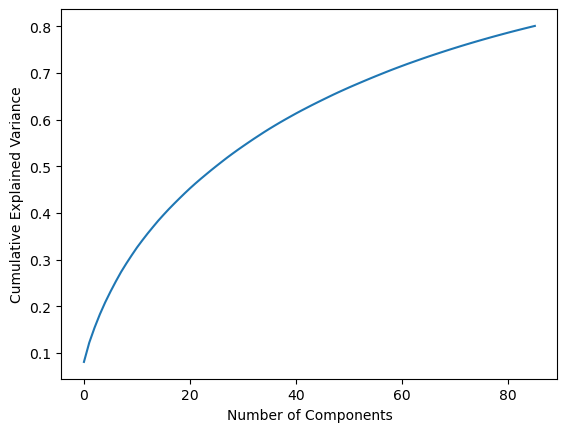

In [70]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Step 1: Convert list of NumPy arrays to a 2D matrix (e.g., a matrix with shape (n_samples, n_features))
X = matrix

# Step 2: Standardize the data (important for PCA)
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Step 3: Apply PCA to reduce dimensionality
pca = PCA(n_components=0.80)  
X_pca = pca.fit_transform(X_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


## Elbow Method, selecting number of Clusters

In [71]:
%env OMP_NUM_THREADS 6
import warnings
warnings.filterwarnings("ignore")

env: OMP_NUM_THREADS=6


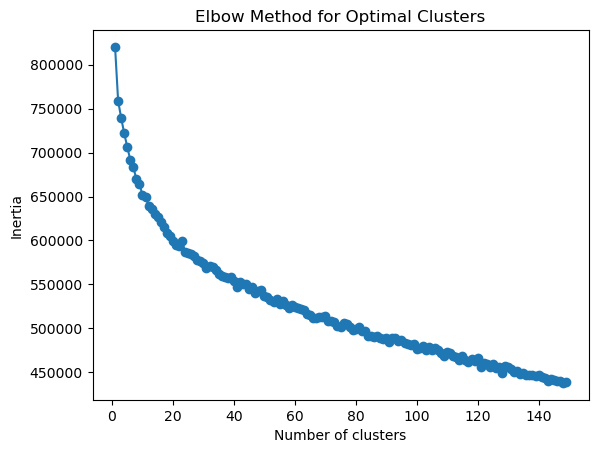

In [72]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate inertia for different numbers of clusters
inertia = []
for k in range(1, 150):  # Try from 1 to 10 clusters
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot inertia to find the "elbow"
plt.plot(range(1, 150), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Clustering 

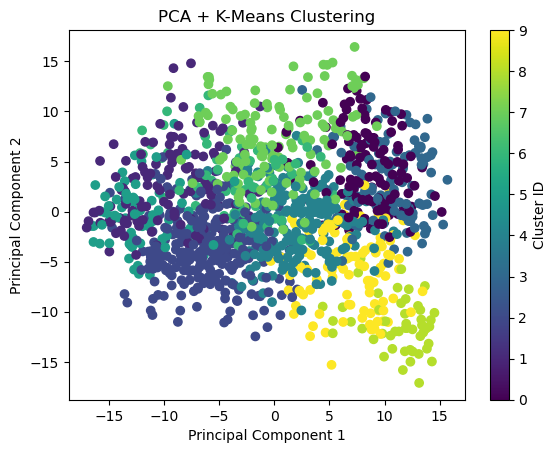

Cluster Centers (in PCA space):
[[ 8.31644440e+00  4.24017429e+00  2.29651070e+00  3.12444896e-01
   2.21318030e+00 -3.22266555e+00 -1.00535667e+00  1.19616091e+00
   5.44761539e-01 -3.10052454e-01 -6.98372781e-01 -1.26269376e+00
   1.08334231e+00  7.07508206e-01  1.62215507e+00 -3.16178589e-03
  -6.75440729e-01 -1.27582026e+00 -8.16465989e-02 -3.56923729e-01
  -5.71197808e-01  7.56608009e-01  3.68617058e-01  4.61538434e-01
  -4.03343946e-01  7.75093138e-02  7.27869868e-02  6.77160025e-01
  -5.16450182e-02 -5.87900639e-01  1.81378070e-02  9.91959870e-02
  -1.42700478e-01  8.37862253e-01 -1.48140430e-01  3.63836996e-02
   9.80796590e-02  3.72478366e-01 -4.39427644e-01 -1.13787353e-01
  -9.01606008e-02 -3.79232205e-02 -2.26353526e-01  4.00196314e-02
   1.47034805e-02 -5.68161368e-01  3.41590010e-02  1.20172203e-01
  -1.25969291e-01  1.13549724e-01  1.58120304e-01  3.53245795e-01
   3.56597453e-01 -1.90534621e-01  3.39062065e-02 -9.43213254e-02
  -2.48552307e-01 -1.82878166e-01  2.0157063

In [139]:
# Step 4: Apply Clustering 
kmeans = KMeans(n_clusters=10)  
kmeans.fit(X_pca)

# Step 5: Visualize the result 
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("PCA + K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

# Step 6: Optionally, print cluster centers
print("Cluster Centers (in PCA space):")
print(kmeans.cluster_centers_)

In [140]:
import pandas as pd
labels = {'labels':kmeans.labels_,}
labels = pd.DataFrame(labels)
labels.groupby('labels').size()

labels
0    128
1    121
2    292
3    124
4    222
5     78
6     74
7    137
8     51
9    107
dtype: int64

In [141]:
bc['cluster'] =kmeans.labels_
bc.head()

book chapter                                               text  \
1  Genesis       1  In the beginning God created heaven, and earth...   
2  Genesis       2  So the heavens and the earth were finished, an...   
3  Genesis       3  Now the serpent was more subtle than any of th...   
4  Genesis       4  And Adam knew Eve his wife; who conceived and ...   
5  Genesis       5  This is the book of the generation of Adam. In...   

                                             encoded  cluster  
1  [0.032561317, 0.073337354, -0.02697155, -0.086...        6  
2  [0.033158623, 0.034816347, -0.00030058404, -0....        6  
3  [0.02034806, 0.009800185, -0.066429794, -0.059...        4  
4  [0.03762339, 0.019744243, -0.07420152, -0.1101...        4  
5  [0.018024927, 0.03639411, -0.05767843, -0.0642...        5

Cluster 0 


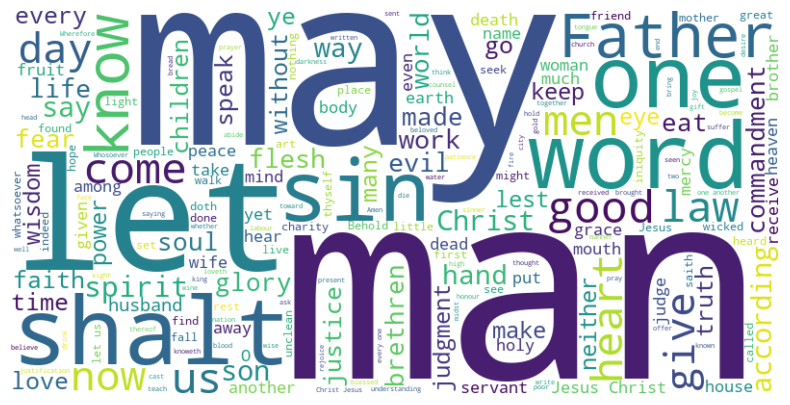

Cluster 1 


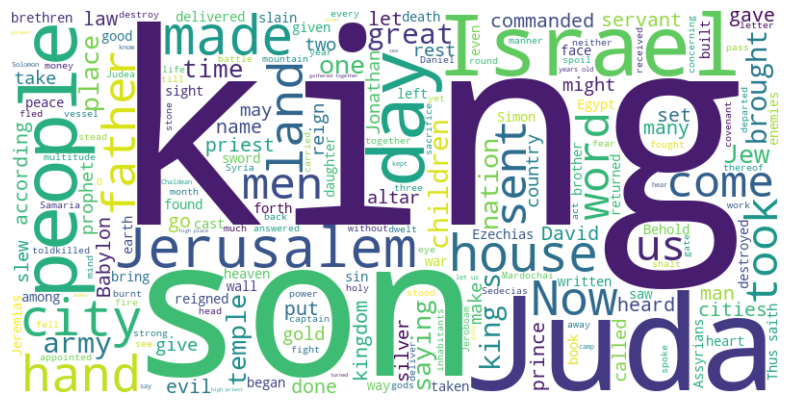

Cluster 2 


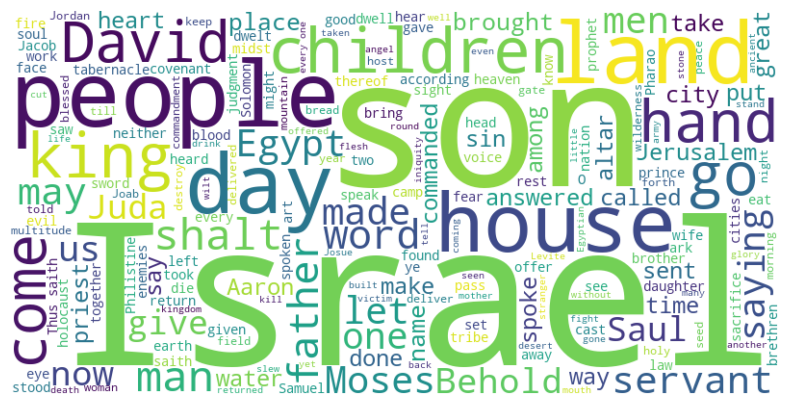

Cluster 3 


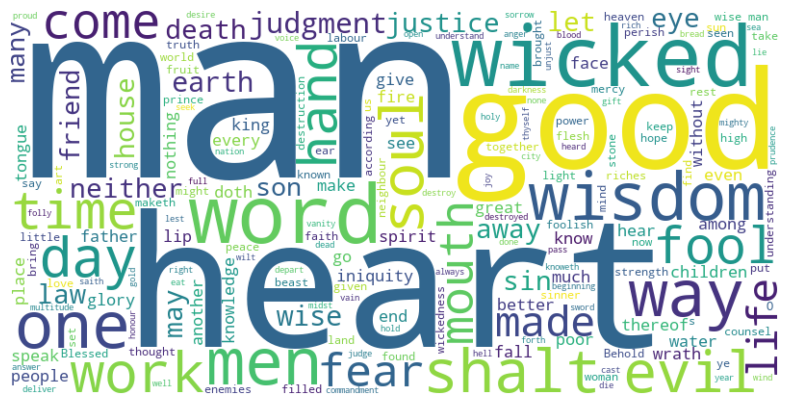

Cluster 4 


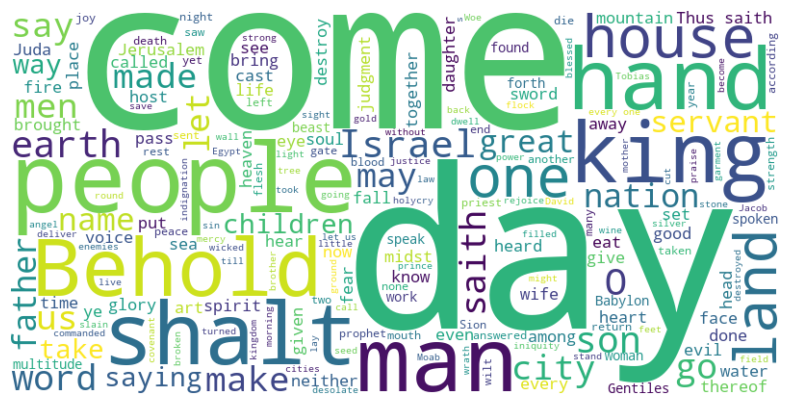

Cluster 5 


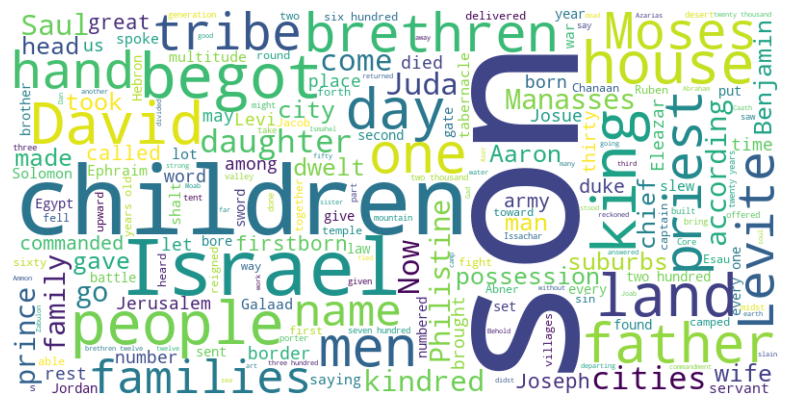

Cluster 6 


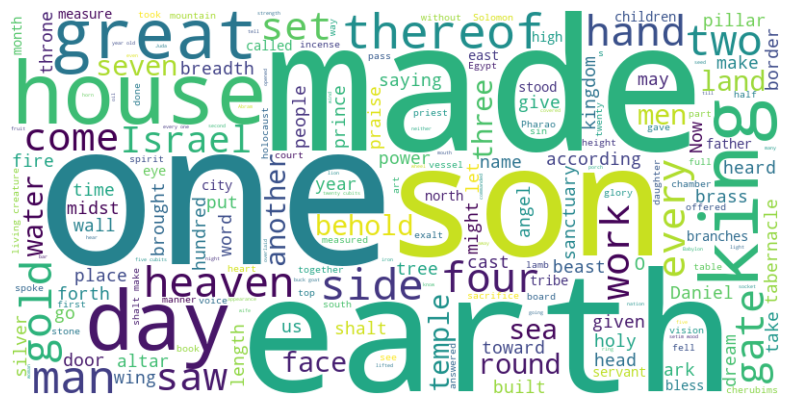

Cluster 7 


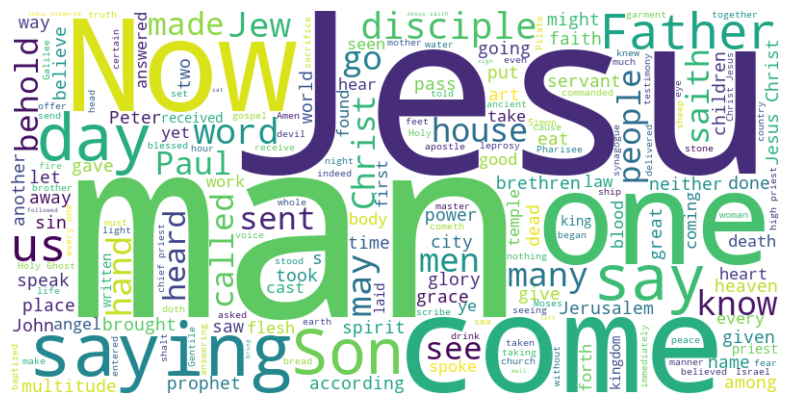

Cluster 8 


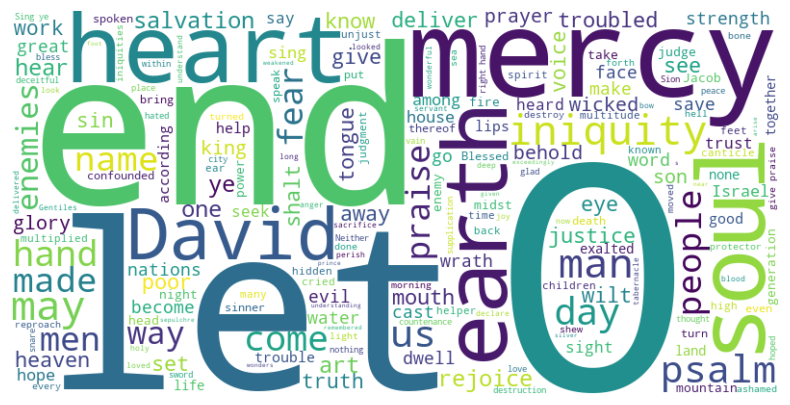

Cluster 9 


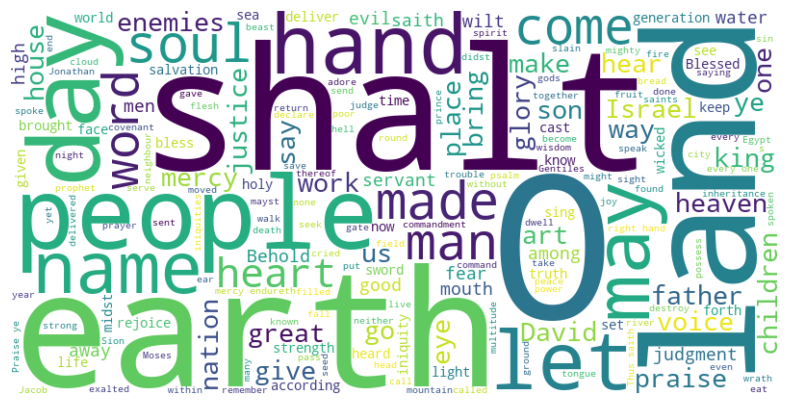

In [155]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(["thy", "thou","thee", "Lord","God","thing","hath","things","hast","upon","unto","came","went","said","will"]) # Extremely common in the source material

for i in range(10):
    txt = '\n'.join(bc.loc[bc['cluster']==i]['text'])
    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='white', 
        stopwords = stopwords,
        colormap='viridis'
    ).generate(txt)
    print (f"Cluster {i} ")
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # No axes
    plt.show()

## Cluster Composition by Book in the Bible

We want to visualize the proportion of verses in the different clusters across each book.

In [143]:
#First we group the verses by cluster and book
books_clusters = bc.groupby(['book','cluster'],as_index=False).size()
books_clusters.head()

book  cluster  size
0  1 Corinthians        0     8
1  1 Corinthians        3     1
2  1 Corinthians        7     7
3       1 Esdras        1     5
4       1 Esdras        2     2

In [144]:
books = bc['book'].unique()
print(books)
print(len(books))

['Genesis' 'Exodus' 'Leviticus' 'Numbers' 'Deuteronomy' 'Josue' 'Judges'
 'Ruth' '1 Kings' '2 Kings' '3 Kings' '4 Kings' '1 Paralipomenon'
 '2 Paralipomenon' '1 Esdras' '2 Esdras' 'Tobias' 'Judith' 'Esther' 'Job'
 'Psalms' 'Proverbs' 'Ecclesiastes' 'Canticle of Canticles' 'Wisdom'
 'Ecclesiasticus' 'Isaias' 'Jeremias' 'Lamentations' 'Baruch' 'Ezechiel'
 'Daniel' 'Osee' 'Joel' 'Amos' 'Abdias' 'Jonas' 'Micheas' 'Nahum'
 'Habacuc' 'Sophonias' 'Aggeus' 'Zacharias' 'Malachias' '1 Machabees'
 '2 Machabees' 'Matthew' 'Mark' 'Luke' 'John' 'Acts' 'Romans'
 '1 Corinthians' '2 Corinthians' 'Galatians' 'Ephesians' 'Philippians'
 'Colossians' '1 Thessalonians' '2 Thessalonians' '1 Timothy' '2 Timothy'
 'Titus' 'Philemon' 'Hebrews' 'James' '1 Peter' '2 Peter' '1 John'
 '2 John' '3 John' 'Jude' 'Apocalypse']
73


In [149]:
# We need to reformat our datafame to allow the desired visualization
new_books_clusters ={'book':books,0:[0]*len(books),1:[0]*73,2:[0]*73,3:[0]*73,4:[0]*73,5:[0]*73,6:[0]*73,7:[0]*73,8:[0]*73,9:[0]*73}
#,10:[0]*73,11:[0]*73,12:[0]*73,13:[0]*73,14:[0]*73,15:[0]*73,16:[0]*73,17:[0]*73,18:[0]*73,19:[0]*73}
new_books_clusters = pd.DataFrame(new_books_clusters)
for i in range(books_clusters.shape[0]):
    new_books_clusters.loc[new_books_clusters['book']==books_clusters.loc[i,'book'],books_clusters.loc[i,'cluster']]=books_clusters.loc[i,'size']

new_books_clusters.fillna(0, inplace=True)
new_books_clusters.head()

book  0  1   2  3  4   5  6  7  8  9
0      Genesis  0  4  18  0  8   8  9  2  0  1
1       Exodus  0  0  24  2  1   2  9  0  0  2
2    Leviticus  2  0  17  0  1   0  0  6  0  1
3      Numbers  1  0  22  0  1  10  1  1  0  0
4  Deuteronomy  7  1  14  0  4   1  1  0  0  6

In [151]:
new_books_clusters.loc[new_books_clusters['book']=='Leviticus']
s=0
for j in range(10):  
    s=s+new_books_clusters.loc[2,j]
    print(s," :: ",new_books_clusters.loc[2,j])

for j in range(10):
    new_books_clusters.loc[2,j]=new_books_clusters.loc[2,j]/s
    print(new_books_clusters.loc[2,j])

2  ::  2
2  ::  0
19  ::  17
19  ::  0
20  ::  1
20  ::  0
20  ::  0
26  ::  6
26  ::  0
27  ::  1
0.07407407407407407
0
0.6296296296296297
0
0.037037037037037035
0
0
0.2222222222222222
0
0.037037037037037035


In [153]:
#Now, we divide by the total number of verses to get percentages 
for i in range(new_books_clusters.shape[0]):
    s=0.0
    for j in range(10):
        s=s+new_books_clusters.loc[i,j]
    for j in range(10):
        new_books_clusters.loc[i,j]=new_books_clusters.loc[i,j]/s
# new_books_clusters.fillna(0, inplace=True)
new_books_clusters.head()

book         0         1         2     3         4         5  \
0      Genesis  0.000000  0.080000  0.360000  0.00  0.160000  0.160000   
1       Exodus  0.000000  0.000000  0.600000  0.05  0.025000  0.050000   
2    Leviticus  0.074074  0.000000  0.629630  0.00  0.037037  0.000000   
3      Numbers  0.027778  0.000000  0.611111  0.00  0.027778  0.277778   
4  Deuteronomy  0.205882  0.029412  0.411765  0.00  0.117647  0.029412   

          6         7    8         9  
0  0.180000  0.040000  0.0  0.020000  
1  0.225000  0.000000  0.0  0.050000  
2  0.000000  0.222222  0.0  0.037037  
3  0.027778  0.027778  0.0  0.000000  
4  0.029412  0.000000  0.0  0.176471

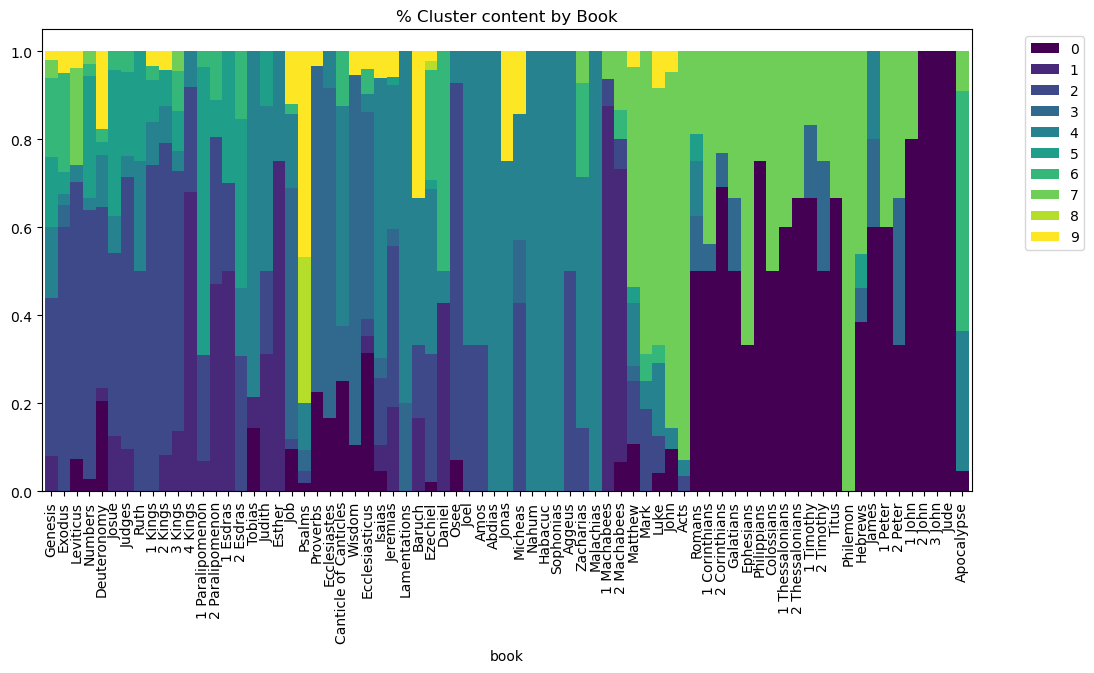

In [154]:
ax = new_books_clusters.plot(x='book', kind='bar', stacked=True,
        title='% Cluster content by Book',figsize=(12, 6), colormap='viridis',width=1.0)


ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Latent Dirichlet Allocation

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(bc.loc[bc['cluster']==1,:]['text'])

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=2, random_state=42) 
lda.fit(X)

# Print top words per topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))

# Assign topics to documents
doc_topic_dist = lda.transform(X)

Topic 0:
figs bad barefoot abimelech amnon adarezer abram sichem eunuchs sodom
Topic 1:
king lord god shall israel son juda thy jerusalem thou


## Other Approaches: UMAP for dimentionality reduction and OPTICS/DBSCAN for clustering

I tried other approaches like using UMAP instead of PCA and OPTICS/DBSCAN instead of knn, however the results were poor. 

In [158]:
import umap.umap_ as umap

In [159]:
reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(X_pca)
embedding = reducer.fit_transform(X_pca)
embedding.shape


(1334, 2)

In [160]:
embedding[:5,:]

array([[3.5765107, 6.036136 ],
       [3.572208 , 6.04922  ],
       [3.8139088, 5.743425 ],
       [3.7468457, 5.493087 ],
       [1.345111 , 4.394867 ]], dtype=float32)

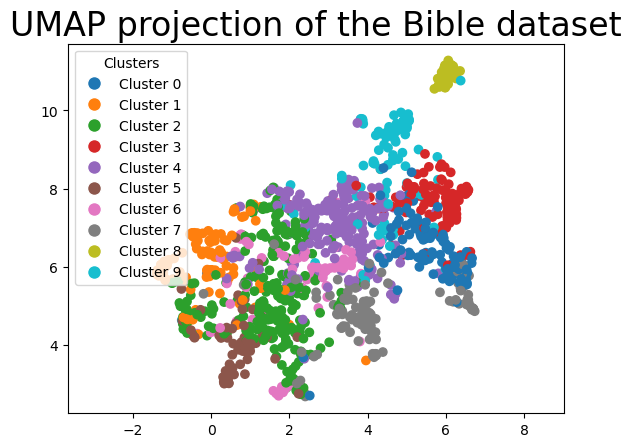

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your existing code
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in bc['cluster']],
    label=[f'Cluster {x}' for x in bc['cluster']]
)

# Manually create legend handles
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sns.color_palette()[x], markersize=10, label=f'Cluster {x}')
    for x in range(len(sns.color_palette()))
]

plt.legend(handles=handles, title='Clusters')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Bible dataset', fontsize=24)
plt.show()


## Classification

We want to explore the authorship of the Pauline Epistles. See (https://en.wikipedia.org/wiki/Pauline_epistles)

There are three groups of epistles based on expert consensus:

* Widely believed to be authored by St. Paul: (Galatians, Romans, 1 Corinthians, 2 Corinthians, Philemon, Philippians, 1 Thessalonians)

* Widely seen as pseudepigraphic :  (1 Timothy, 2 Timothy, and Titus)

* Divided opinion: (2 Thessalonians, Ephesians and Colossians)

Hebrews was traditionally considered Pauline, however, now most experts do not consider it of his authorship.


## Strategy

I'm interested to see if the semantic encoding can show something interesting regarding the authorships of the epistles where there is no consensus. so the idea is:

1.- Train a binary classifier on the epistles where there is consensus (authored by St Paul and pseudoepigraphic) 
2.- Predict on the ones with Divided Opinion + Hebrews and compare the results.

I'll use gradient boosting as the classification technique.

## Data Preparation

In [234]:
authored = ['Galatians', '1 Corinthians', '2 Corinthians','Philemon','Philippians','1 Thessalonians']
pseudo = ['1 Timothy', 'Titus']
divided = ['2 Thessalonians','Ephesians', 'Colossians', 'Hebrews','Romans', '2 Timothy' ] # Added Hebrews here also Romans (authered) and 2 Tim (pseudp)

train = bc.loc[bc['book'].isin( authored + pseudo )]
train['flag'] = [1 if x in set(authored) else 0 for x in  train['book']]
train.head()

book chapter  \
1208  1 Corinthians       1   
1209  1 Corinthians       2   
1210  1 Corinthians       3   
1211  1 Corinthians       4   
1212  1 Corinthians       5   

                                                   text  \
1208  Paul, called to be an apostle of Jesus Christ ...   
1209  And I, brethren, when I came to you, came not ...   
1210  And I, brethren, could not speak to you as unt...   
1211  Let a man so account of us as of the ministers...   
1212  It is absolutely heard that there is fornicati...   

                                                encoded  cluster  flag  
1208  [0.016775828, 0.09037156, -0.040853854, -0.082...        7     1  
1209  [0.031925157, 0.043785583, -0.03291162, -0.041...        0     1  
1210  [0.08237594, 0.082213886, -0.04893608, -0.0364...        7     1  
1211  [0.063401915, 0.05332147, -0.030539973, -0.034...        0     1  
1212  [0.07916457, 0.03799441, -0.061410908, -0.0670...        0     1

In [235]:
from sklearn.model_selection import train_test_split

# Data Set
X, y = np.array([np.array(m) for m in train['encoded']]), train['flag']


In [236]:

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingClassifier


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Create a GradientBoostingClassifier model
gbc = GradientBoostingClassifier()

# Create a K-Folds cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=kf, scoring='accuracy')
grid_search.fit(X, y)

# Display the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")


Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best cross-validation accuracy: 0.8345454545454546


In [237]:
train['predictions'] = [x[1] for x in grid_search.predict_proba(X)]


<Axes: xlabel='book,flag'>

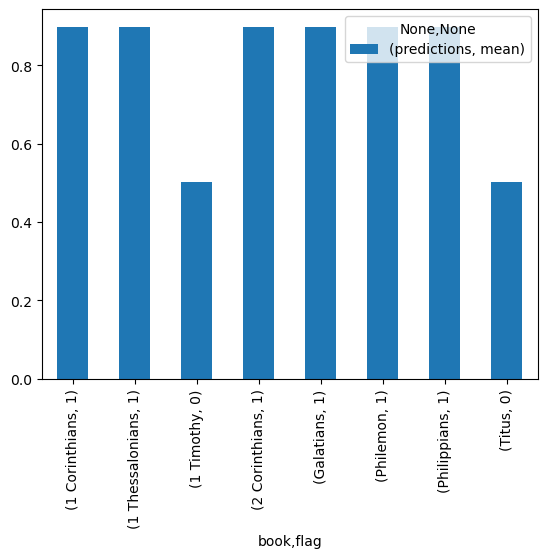

In [238]:
train.groupby(['book','flag']).agg({'predictions':['mean']}).plot(kind='bar')

In [239]:
test = bc.loc[bc['book'].isin( divided )]
X_test = np.array([np.array(m) for m in test['encoded']])

In [240]:
X_test.shape

(46, 768)

<Axes: xlabel='book'>

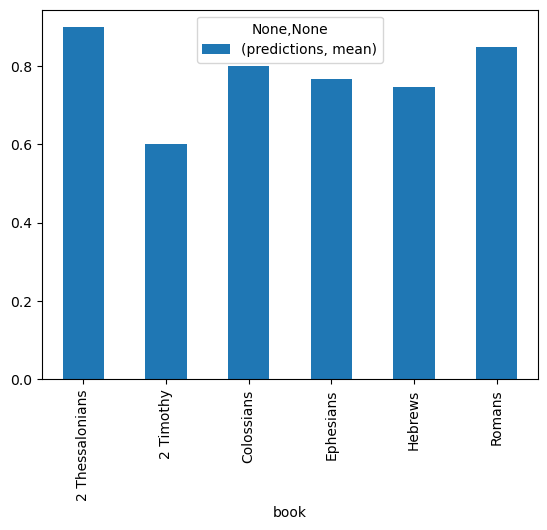

In [241]:
test['predictions'] = [x[1] for x in grid_search.predict_proba(X_test)]
test.groupby(['book']).agg({'predictions':['mean']}).plot(kind='bar')

In [206]:
test

book chapter  \
1243        Ephesians       1   
1244        Ephesians       2   
1245        Ephesians       3   
1246        Ephesians       4   
1247        Ephesians       5   
1248        Ephesians       6   
1253       Colossians       1   
1254       Colossians       2   
1255       Colossians       3   
1256       Colossians       4   
1262  2 Thessalonians       1   
1263  2 Thessalonians       2   
1264  2 Thessalonians       3   
1279          Hebrews       1   
1280          Hebrews       2   
1281          Hebrews       3   
1282          Hebrews       4   
1283          Hebrews       5   
1284          Hebrews       6   
1285          Hebrews       7   
1286          Hebrews       8   
1287          Hebrews       9   
1288          Hebrews      10   
1289          Hebrews      11   
1290          Hebrews      12   
1291          Hebrews      13   

                                                   text  \
1243  Paul, an apostle of Jesus Christ, by the will ...   
1244  And you, when you were dead in your offences a...   
1245  For this cause, I Paul, the prisoner of Jesus ...   
1246  I therefore, a prisoner in the Lord, beseech y...   
1247  Be ye therefore followers of God, as most dear...   
1248  Children, obey your parents in the Lord: for t...   
1253  Paul, an apostle of Jesus Christ, by the will ...   
1254  For I would have you know what manner of care ...   
1255  Therefore if you be risen with Christ, seek th...   
1256  Masters, do to your servants that which is jus...   
1262  Paul and Sylvanus and Timothy, to the church o...   
1263  And we beseech you, brethren, by the coming of...   
1264  For the rest, brethren, pray for us that the w...   
1279  God, who, at sundry times and in divers manner...   
1280  Therefore ought we more diligently to observe ...   
1281  Wherefore, holy brethren, partakers of the hea...   
1282  Let us fear therefore lest, the promise being ...   
1283  For every high priest taken from among men is ...   
1284  Wherefore, leaving the word of the beginning o...   
1285  For this Melchisedech was king of Salem, pries...   
1286  Now of the things which we have spoken, this i...   
1287  The former indeed had also justifications of d...   
1288  For the law, having a shadow of the good thing...   
1289  Now, faith is the substance of things to be ho...   
1290  And therefore we also having so great a cloud ...   
1291  Let the charity of the brotherhood abide in yo...   

                                                encoded  cluster  predictions  
1243  [0.05801173, 0.06999966, -0.06175462, -0.06604...        7            1  
1244  [0.05457186, 0.0008355573, -0.09888028, -0.041...        7            1  
1245  [-0.017434616, 0.03279217, -0.07250915, -0.039...        7            1  
1246  [0.018408412, 0.04223703, -0.028836261, -0.056...        7            1  
1247  [0.040979493, 0.036173176, -0.05105585, -0.061...        0            1  
1248  [-0.0010254552, 0.03581417, -0.016326444, -0.0...        0            1  
1253  [0.017592832, 0.07380896, -0.03312464, -0.0598...        7            1  
1254  [0.04225461, 0.029168483, -0.10747096, -0.0436...        0            1  
1255  [0.042402472, 0.052038126, -0.04742967, -0.041...        0            1  
1256  [0.029231252, 0.058092397, -0.03384576, -0.045...        7            1  
1262  [0.043780547, 0.054993328, -0.034722377, -0.06...        7            1  
1263  [-0.012738124, 0.03679814, -0.07468078, -0.053...        0            1  
1264  [0.0021607804, 0.047386207, -0.06937961, -0.05...        0            1  
1279  [-0.03910119, 0.016401643, -0.058467265, -0.05...        3            1  
1280  [0.018513037, 0.06823214, -0.031670716, -0.064...        7            1  
1281  [0.047525447, 0.07063049, -0.017334407, -0.075...        7            1  
1282  [0.034873776, 0.016715178, -0.023903774, -0.07...        0            1  
1283  [-0.0009099682, 0.042897776, -0.019653408, -0....        7            1  
1284  [0.04